In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [5]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [6]:
from model_PyG import *
from utils import *

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [8]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


### Utils

In [9]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_attr))

def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

### Setup

In [10]:
dataset = "deybis_filter_september_05" # "deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
encoder = "GIN" # Change GIN, GINE
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100
elif (dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05"]):
	train_set = [
		# "FrescoAmazonas_1", "FrescoAmazonas_2",
		# "FrescoCusco_1", "FrescoCusco_2",
		# "FrescoSanMartin_1", "FrescoSanMartin_2",
		# "SecoAmazonas_1", "SecoAmazonas_2",
		# "SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)
edge_attr = torch.tensor([
	[0.5, 1.0], 
	[0.5, 1.0], 
	[1.0, 1.5], 
	[1.0, 1.5]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

print(data)
info(data)

transform = T.Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

data = transform(data)
print(data)
info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [11]:
# Only for GIN
""" transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

In [ ]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		edge_attr = torch.ones((edge_index.size(1), 1)) # Only for test GINE

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		info(data)

		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]: # Change
	features = [0, 1, 2, 4, 5]

	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, 0, 1, 2, ...

		df_intensity = df_nodes.iloc[:, 4:]
		# 0, 1, 2, ...

		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup

		# Node features
		""" mz = np.log10(df_nodes["mz"].values + 1e-8) # Log-transform m/z to stabilize scale differences
		rt = df_nodes["rt"].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8) # Z-score normalization for retention time (RT)

		intensity = df_intensity.values.astype(np.float32)
		intensity = intensity / (intensity.sum(axis=0, keepdims=True) + 1e-8)
		intensity_mean = intensity.mean(axis=1)

		intensity_std = intensity.std(axis=1)
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		intensity_cv = np.log1p(np.clip(intensity_cv, 0, 2.0))

		presence_ratio = (df_intensity > 0).mean(axis=1) # Acts as a reliability / confidence signal """

		# df_intensity = np.sign(df_intensity) * np.log10(np.abs(df_intensity) + 1e-8)

		mz = np.log10(df_nodes.iloc[:, 2].values + 1e-8)
		rt = df_nodes.iloc[:, 3].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8)
		intensity_mean = df_intensity.mean(axis=1).values
		intensity_std = df_intensity.std(axis=1).values
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		presence_ratio = (df_intensity > 0).mean(axis=1) # Import to check

		x = np.stack([
				mz,             			# 0 physicochemical identity
				rt,							# 1 chromatographic alignment
				np.log10(intensity_mean + 1e-8), 	# 2 global abundance
				intensity_std,  			# 3
				intensity_cv,   			# 4 robustness (anti-oversmoothing)
				presence_ratio  			# 5 reliability
			], axis=1)

		x = torch.tensor(x[:, features], dtype=torch.float) # [N, F]
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		# Edge index
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values.T, dtype=torch.long) # [2, E]

		# Edge attribute
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]

		# edge_attr = edge_weight.view(-1, 1) # [E,1]
		edge_attr = torch.stack([
							edge_weight.abs(),        # strength
							torch.sign(edge_weight),  # direction (+1, -1)
							edge_weight ** 2          # nonlinearity
						], dim=1) # [E, 3]

		# Reduce number of edges
		""" mask = torch.abs(edge_weight) > 0.95
		edge_index = edge_index[:, mask]
		edge_attr  = edge_attr[mask] """

		data = Data(x=x, edge_index=edge_index.contiguous(), edge_attr=edge_attr)

		data = transform(data)
		# data = data.to(device)

		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 162
Num. edges:	 17892
Num. features:	 5
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[  0,   0,   0,  ..., 159, 160, 161],
        [  1,   2,   3,  ..., 159, 160, 161]], device='cuda:1')
tensor([[ 2.2228, -1.4650,  6.5302,  0.4736,  1.0000],
        [ 2.1820, -1.3916,  6.1067,  0.3217,  1.0000],
        [ 2.4116, -1.3906,  6.7842,  0.8142,  1.0000],
        [ 2.3180, -1.3900,  7.0607,  0.7774,  1.0000],
        [ 2.3384, -1.3890,  6.9556,  0.0726,  1.0000],
        [ 2.1820, -1.3645,  7.0141,  0.4849,  1.0000],
        [ 2.1820, -1.3627,  7.0124,  0.5032,  1.0000],
        [ 2.2555, -1.3559,  6.6384,  0.3535,  1.0000],
        [ 2.2603, -1.3481,  6.8890,  0.3499,  1.0000],
        [ 2.1338, -1.3479,  6.8632,  0.3707,  1.0000],
        [ 2.2881, -1.3451,  6.0529,  0.6432,  1.0000],
        [ 2.3930, -1.3447,  5.4377,  0.9464,  1.0000],
        [ 2.2555, -1.3437,  5.8244,  0.4594,  1.0000],


In [13]:
train_loader

{'SecoSanMartin_1': Data(x=[162, 5], edge_index=[2, 17892], edge_attr=[17892, 3]),
 'SecoSanMartin_2': Data(x=[162, 5], edge_index=[2, 17672], edge_attr=[17672, 3])}

### Train

In [14]:
def fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]

			# Encoder
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
				# z = F.normalize(z, dim=1)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)

			# Positive edges
			pos_edge_index = data.edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=data.edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)
			dict_node_embeddings[ts] = z.cpu().numpy()

	del loss, z
	# torch.cuda.synchronize()
	torch.cuda.empty_cache()
	
	return dict_node_embeddings, list_loss

In [15]:
train_set

['SecoSanMartin_1', 'SecoSanMartin_2']

In [16]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

if encoder == "GIN":
	model = TGAE_GIN(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)
elif encoder == "GINE":
	edge_dim = train_loader[train_set[0]].edge_attr.size(1)

	model = TGAE_GINE(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size, edge_dim).to(device)

print("Generating training features")
print("Fitting model")
print(encoder, dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
GIN deybis_filter_september_05 0.0001 100 5 128 2


Epoch: 100: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s, Loss: 0.6383]


### Get embeddings

In [17]:
dict_node_embeddings

{'SecoSanMartin_1': array([[ 0.04595777,  0.01816611, -0.01781166, ..., -0.02081829,
         -0.06181182,  0.07151206],
        [ 0.05275097,  0.02597829, -0.0281731 , ..., -0.02049431,
         -0.05188673,  0.12354672],
        [ 0.03715235,  0.0176978 ,  0.00092273, ..., -0.02239403,
         -0.05174597,  0.02023955],
        ...,
        [-0.00802319, -0.02833659,  0.02078043, ...,  0.01153765,
          0.00356478, -0.09024682],
        [ 0.00315461, -0.01893708,  0.01989869, ..., -0.00320412,
          0.00092933, -0.07175434],
        [ 0.03607978, -0.00148596, -0.00654535, ..., -0.03066593,
         -0.00877162,  0.03560947]], dtype=float32),
 'SecoSanMartin_2': array([[ 2.72677131e-02,  1.42149357e-02,  1.10577708e-02, ...,
         -1.38312634e-02, -5.27985618e-02, -1.24503747e-02],
        [ 5.12595251e-02,  3.33260410e-02, -2.99242195e-02, ...,
         -1.73015110e-02, -3.96382883e-02,  1.45620853e-01],
        [ 4.96971160e-02,  1.02219172e-04, -1.61819384e-02, ...,
   

### Plot

In [18]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(324, 128)


array([[ 0.04595777,  0.01816611, -0.01781166, ..., -0.02081829,
        -0.06181182,  0.07151206],
       [ 0.05275097,  0.02597829, -0.0281731 , ..., -0.02049431,
        -0.05188673,  0.12354672],
       [ 0.03715235,  0.0176978 ,  0.00092273, ..., -0.02239403,
        -0.05174597,  0.02023955],
       ...,
       [-0.01499697, -0.04918323,  0.03485125, ..., -0.00386015,
        -0.01153659, -0.18716176],
       [-0.00707804, -0.03083305,  0.0221476 , ..., -0.00184245,
         0.00695188, -0.10507223],
       [ 0.00942505, -0.03967269,  0.00711765, ..., -0.02101305,
        -0.02336367, -0.09362475]], dtype=float32)

In [19]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
	labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

324
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [20]:
list_loss

[5.558095932006836,
 5.582489967346191,
 1.7111973762512207,
 1.1937479972839355,
 1.1361005306243896,
 0.8859035968780518,
 0.7177577614784241,
 0.6866769790649414,
 0.693912148475647,
 0.6879042983055115,
 0.6665210723876953,
 0.6456616520881653,
 0.6364785432815552,
 0.6361826658248901,
 0.6386932134628296,
 0.6395680904388428,
 0.6379700899124146,
 0.6357094049453735,
 0.6336626410484314,
 0.6319187879562378,
 0.6302014589309692,
 0.6284550428390503,
 0.6271557807922363,
 0.626426637172699,
 0.6260576248168945,
 0.6258991956710815,
 0.6257359385490417,
 0.6255390644073486,
 0.625440239906311,
 0.6253827810287476,
 0.625328779220581,
 0.6252673864364624,
 0.6251460909843445,
 0.625012993812561,
 0.6249026656150818,
 0.6247830390930176,
 0.6246771812438965,
 0.6245714426040649,
 0.624436616897583,
 0.6243082284927368,
 0.6241786479949951,
 0.6240400075912476,
 0.6239058971405029,
 0.6237537860870361,
 0.6236006021499634,
 0.6234480142593384,
 0.6232900619506836,
 0.6231417655944824,


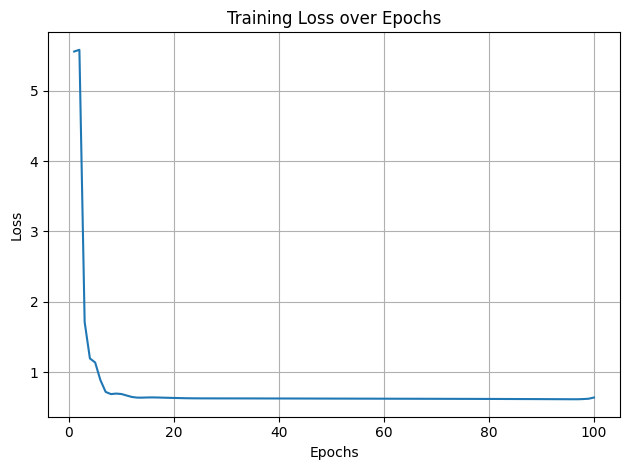

In [21]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/loss_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

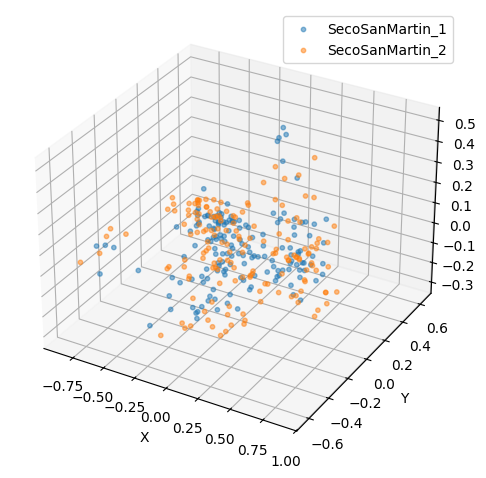

In [22]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

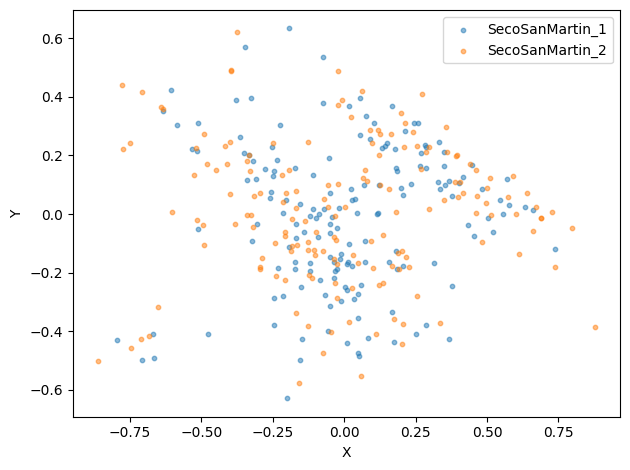

In [23]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/node_embeddings_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Similarity analysis (KNN)

In [24]:
train_set

['SecoSanMartin_1', 'SecoSanMartin_2']

In [25]:
# Get node ids

dict_node_id = {}

if dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
	for ts in train_set:
		dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'SecoSanMartin_1': array([  0,   1,   2,   3,   4,   6,   7,   8,  10,  11,  13,  14,  15,
         17,  19,  20,  25,  26,  27,  28,  29,  30,  32,  34,  35,  37,
         38,  39,  40,  43,  44,  45,  46,  48,  49,  50,  52,  53,  54,
         55,  57,  61,  63,  66,  67,  70,  71,  72,  73,  74,  80,  81,
         82,  83,  84,  85,  86,  89,  90,  93,  94,  96,  97, 100, 101,
        102, 103, 104, 106, 107, 108, 109, 110, 112, 114, 115, 117, 118,
        120, 124, 125, 127, 128, 132, 135, 136, 139, 140, 142, 143, 144,
        148, 149, 152, 153, 154, 155, 157, 158, 160, 161,   5,   9,  16,
         18,  22,  23,  24,  31,  33,  41,  42,  47,  51,  56,  58,  60,
         62,  68,  69,  75,  76,  78,  79,  91,  92,  95,  98,  99, 111,
        116, 119, 121, 122, 123, 126, 130, 131, 133, 134, 137, 138, 141,
        145, 146, 147, 150, 151, 156, 159,  64, 113, 129,  12,  36,  77,
         87,  21,  59,  65,  88, 105]),
 'SecoSanMartin_2': array([  0,   1,   4,   5,   6,   7,   8,   9

In [26]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	indices = indices.squeeze() # (N,)

	df_node_alignment[ts] = dict_node_id[ts][indices]
	df_node_alignment[f"distances"] = distances
df_node_alignment

,SecoSanMartin_1,SecoSanMartin_2,distances
0,0,10,0.050379
1,1,1,0.089355
2,2,38,0.139057
3,3,41,0.078841
4,4,28,0.117308
...,...,...,...
157,21,40,0.089681
158,59,59,0.094306
159,65,73,0.121038
160,88,69,0.037338


In [27]:
df_node_alignment.describe()

,SecoSanMartin_1,SecoSanMartin_2,distances
count,162.000000,162.000000,162.000000
mean,80.500000,80.993827,0.109227
std,46.909487,47.508940,0.047458
min,0.000000,1.000000,0.035153
25%,40.250000,39.250000,0.078653
50%,80.500000,78.500000,0.101825
75%,120.750000,126.000000,0.123938
max,161.000000,161.000000,0.308710


In [28]:
avg_distances = df_node_alignment["distances"].mean()
avg_distances

0.10922726452994494

In [29]:
df_node_alignment = df_node_alignment[df_node_alignment["distances"] <= avg_distances].iloc[:, :-1]
df_node_alignment

,SecoSanMartin_1,SecoSanMartin_2
0,0,10
1,1,1
3,3,41
5,6,18
6,7,18
...,...,...
156,87,77
157,21,40
158,59,59
160,88,69


In [30]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

SecoSanMartin_1 SecoSanMartin_2


,SecoSanMartin_1,SecoSanMartin_2
1,1,1
16,25,25
17,26,26
23,34,34
45,70,70
50,80,80
54,84,84
57,89,89
61,96,96
71,109,109


In [31]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

22


,SecoSanMartin_1,SecoSanMartin_2
1,1,1
16,25,25
17,26,26
23,34,34
45,70,70
50,80,80
54,84,84
57,89,89
61,96,96
71,109,109


In [32]:
# Comparison (with test_pairs)

if dataset not in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [33]:
common_node_id = df_node_alignment_filter.iloc[:, 0].values
common_node_id

array([  1,  25,  26,  34,  70,  80,  84,  89,  96, 109, 125, 157, 161,
        16,  68,  91, 126, 133, 145, 159,  77,  59])

In [34]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,1.754,167.01318,unknown,2.102369e+07,5.191424e+06,2.297892e+06,3.229474e+07,3.107148e+07,5.171922e+06,2.880494e+07,...,1.720800e+06,5.260539e+06,5.884508e+06,2.032107e+06,4.365939e+06,5.541052e+06,1.244700e+06,3.412579e+07,1.300488e+07,7.499824e+06
1,2.120,152.05702,unknown,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
2,2.125,257.96816,unknown,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,2.128,207.98572,unknown,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
4,2.133,217.96001,unknown,9.418357e+06,9.172249e+06,1.434368e+07,1.256749e+07,1.200879e+07,1.610727e+07,1.448343e+07,...,2.158761e+07,9.322098e+06,9.037713e+06,1.298658e+07,1.090200e+07,1.103374e+07,1.543508e+07,1.196644e+07,1.212436e+07,2.462687e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,5.709668e+06,5.691558e+06,4.908186e+06,8.214671e+06,8.060828e+06,7.154128e+06,6.951144e+06,...,6.457166e+06,5.127135e+06,4.955646e+06,4.566583e+06,4.639459e+06,4.602868e+06,3.850485e+06,8.845150e+06,9.611742e+06,8.629254e+06
158,22.679,520.34109,unknown,1.034447e+07,1.153674e+07,3.173041e+07,1.338164e+06,1.248430e+06,4.271653e+06,3.965387e+05,...,3.035556e+07,1.844937e+07,1.903460e+07,5.936571e+07,1.951251e+07,1.939011e+07,5.120970e+07,5.499485e+05,5.482506e+05,1.901125e+06
159,23.180,200.20136,unknown,7.190209e+06,6.419463e+06,1.939271e+07,9.675436e+06,9.527342e+06,3.067538e+07,9.600671e+06,...,2.646694e+07,5.868539e+06,6.047440e+06,1.754588e+07,5.603531e+06,6.290763e+06,1.664977e+07,1.037119e+07,1.042731e+07,3.352375e+07
160,24.234,496.34082,unknown,2.836296e+07,2.610888e+07,5.500906e+07,3.428636e+07,3.042322e+07,6.613276e+07,2.900143e+07,...,5.965081e+07,2.516866e+07,2.516913e+07,5.005681e+07,2.480254e+07,2.506261e+07,4.261884e+07,3.936421e+07,3.870481e+07,7.023319e+07


In [35]:
print(len(common_node_id), len(df_join_raw))

22 162


In [36]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
# df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment_{encoder}_{dataset}_{train_set}.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
1,2.120,152.05702,unknown
25,3.116,181.07240,unknown
26,3.118,182.06954,unknown
34,3.347,181.07233,unknown
70,9.627,132.04475,unknown
80,9.805,658.26158,unknown
84,9.822,132.04466,unknown
89,9.823,325.11871,unknown
96,10.235,491.20335,unknown
109,11.441,419.18201,unknown


In [37]:
# Comparison (sta vs Vanessa)

list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)

['SecoSanMartin_1', 'SecoSanMartin_2']
Alignment: 22 / 162
Match comp: 5/23
{70, 91, 157, 126, 159}


In [38]:
df_join_raw.loc[list(match)].iloc[:, :3]

,Average Rt,Average Mz,Metabolite name
70,9.627,132.04475,unknown
91,9.823,473.13284,unknown
157,20.487,501.26053,unknown
126,11.975,287.10311,unknown
159,23.180,200.20136,unknown


### Clustering analysis

In [39]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,1.754,167.01318,unknown,2.102369e+07,5.191424e+06,2.297892e+06,3.229474e+07,3.107148e+07,5.171922e+06,2.880494e+07,...,1.720800e+06,5.260539e+06,5.884508e+06,2.032107e+06,4.365939e+06,5.541052e+06,1.244700e+06,3.412579e+07,1.300488e+07,7.499824e+06
1,2.120,152.05702,unknown,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
2,2.125,257.96816,unknown,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,2.128,207.98572,unknown,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
4,2.133,217.96001,unknown,9.418357e+06,9.172249e+06,1.434368e+07,1.256749e+07,1.200879e+07,1.610727e+07,1.448343e+07,...,2.158761e+07,9.322098e+06,9.037713e+06,1.298658e+07,1.090200e+07,1.103374e+07,1.543508e+07,1.196644e+07,1.212436e+07,2.462687e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,5.709668e+06,5.691558e+06,4.908186e+06,8.214671e+06,8.060828e+06,7.154128e+06,6.951144e+06,...,6.457166e+06,5.127135e+06,4.955646e+06,4.566583e+06,4.639459e+06,4.602868e+06,3.850485e+06,8.845150e+06,9.611742e+06,8.629254e+06
158,22.679,520.34109,unknown,1.034447e+07,1.153674e+07,3.173041e+07,1.338164e+06,1.248430e+06,4.271653e+06,3.965387e+05,...,3.035556e+07,1.844937e+07,1.903460e+07,5.936571e+07,1.951251e+07,1.939011e+07,5.120970e+07,5.499485e+05,5.482506e+05,1.901125e+06
159,23.180,200.20136,unknown,7.190209e+06,6.419463e+06,1.939271e+07,9.675436e+06,9.527342e+06,3.067538e+07,9.600671e+06,...,2.646694e+07,5.868539e+06,6.047440e+06,1.754588e+07,5.603531e+06,6.290763e+06,1.664977e+07,1.037119e+07,1.042731e+07,3.352375e+07
160,24.234,496.34082,unknown,2.836296e+07,2.610888e+07,5.500906e+07,3.428636e+07,3.042322e+07,6.613276e+07,2.900143e+07,...,5.965081e+07,2.516866e+07,2.516913e+07,5.005681e+07,2.480254e+07,2.506261e+07,4.261884e+07,3.936421e+07,3.870481e+07,7.023319e+07


In [40]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:] # Important two last column no only to Mentos 3:-2
df_join_raw_signal

,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,FrescoSanMartin_2.2,FrescoSanMartin_2.3,FrescoCusco_1.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
1,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,5.889561e+05,4.703733e+05,7.333192e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
25,1.760667e+07,1.628310e+07,6.022952e+07,3.069929e+07,3.568783e+07,1.525256e+08,4.518529e+07,3.430235e+07,1.673136e+08,3.871150e+07,...,1.174762e+08,1.616656e+07,2.010994e+07,6.513166e+07,2.438256e+07,1.825917e+07,6.922270e+07,3.458965e+07,3.210725e+07,1.349876e+08
26,2.103618e+05,2.326174e+05,6.176089e+05,5.011401e+05,5.718729e+05,1.828277e+06,5.984180e+05,3.858499e+05,1.532058e+06,4.138760e+05,...,1.339943e+06,2.770326e+05,2.496963e+05,6.339975e+05,3.201600e+05,3.169302e+05,6.670274e+05,4.882497e+05,3.416695e+05,1.229867e+06
34,7.043999e+08,7.040702e+08,1.598353e+09,1.449807e+09,1.418464e+09,3.349387e+09,1.382662e+09,1.373246e+09,3.323827e+09,1.335029e+09,...,2.995214e+09,6.827098e+08,7.015026e+08,1.712788e+09,7.879010e+08,7.877048e+08,1.761120e+09,1.309048e+09,1.335186e+09,3.363967e+09
70,1.013199e+08,1.028140e+08,5.770561e+06,1.343730e+08,1.373691e+08,8.541997e+06,4.718504e+07,1.282548e+08,8.157586e+06,1.360227e+08,...,8.422699e+06,8.756689e+07,8.741793e+07,5.120618e+06,8.503219e+07,8.066671e+07,2.130925e+06,1.572994e+08,5.096799e+07,9.789906e+06
80,5.911525e+06,5.897034e+06,1.799238e+06,1.029808e+07,9.522494e+06,2.265534e+06,1.067889e+07,1.123652e+07,3.043720e+06,7.433415e+06,...,2.382625e+06,5.471126e+06,4.440049e+06,1.335441e+06,5.188455e+06,5.093849e+06,1.414289e+06,1.035205e+07,1.215609e+07,2.191900e+06
84,1.571036e+08,1.339136e+08,8.303704e+06,2.026872e+08,1.924726e+08,1.380518e+07,2.123047e+08,1.664979e+08,1.422396e+07,1.888537e+08,...,1.407739e+07,1.291050e+08,1.352295e+08,8.574059e+06,1.260617e+08,1.257000e+08,9.053218e+06,2.219323e+08,2.254405e+08,1.569956e+07
89,1.839040e+07,1.754240e+07,7.283363e+05,2.876141e+07,2.592491e+07,1.347136e+06,2.733925e+07,2.207974e+07,1.973380e+06,2.819465e+07,...,2.075502e+06,1.667228e+07,1.546079e+07,6.098037e+05,1.586150e+07,1.572169e+07,1.182462e+06,2.805440e+07,2.958979e+07,2.225490e+06
96,1.535213e+07,1.518586e+07,3.584290e+06,2.053389e+07,2.085194e+07,5.854763e+06,2.021705e+07,1.925315e+07,5.888922e+06,2.041144e+07,...,6.413310e+06,1.392893e+07,1.324552e+07,3.663400e+06,1.276428e+07,1.151725e+07,3.761155e+06,2.402621e+07,2.209912e+07,7.651951e+06
109,1.218515e+07,1.028443e+07,4.013776e+05,1.580568e+07,1.591351e+07,1.842382e+06,1.467182e+07,1.355102e+07,1.875735e+06,1.345277e+07,...,1.886868e+06,1.144775e+07,9.306083e+06,1.109343e+06,9.010639e+06,8.051621e+06,1.107438e+06,1.658782e+07,1.474428e+07,2.204212e+06


In [41]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,1,25,26,34,70,80,84,89,96,109,...,161,16,68,91,126,133,145,159,77,59
SecoAmazonas_1.1,2.420068e+06,1.760667e+07,2.103618e+05,7.043999e+08,1.013199e+08,5.911525e+06,1.571036e+08,1.839040e+07,1.535213e+07,1.218515e+07,...,2.889893e+07,28794677.58,1.364561e+07,8.778724e+07,3.591984e+06,1.241192e+07,5.324063e+06,7.190209e+06,1.144139e+09,39243723.39
SecoAmazonas_1.2,2.307995e+06,1.628310e+07,2.326174e+05,7.040702e+08,1.028140e+08,5.897034e+06,1.339136e+08,1.754240e+07,1.518586e+07,1.028443e+07,...,2.822468e+07,30999762.53,1.424307e+07,8.610533e+07,2.744221e+06,1.331434e+07,5.749553e+06,6.419463e+06,1.159910e+09,36652509.76
SecoAmazonas_1.3,5.114995e+06,6.022952e+07,6.176089e+05,1.598353e+09,5.770561e+06,1.799238e+06,8.303704e+06,7.283363e+05,3.584290e+06,4.013776e+05,...,8.887856e+07,48979060.79,1.388814e+05,4.444579e+06,1.119015e+06,1.698941e+07,6.156534e+06,1.939271e+07,4.727884e+07,40842831.11
FrescoSanMartin_1.1,5.664406e+05,3.069929e+07,5.011401e+05,1.449807e+09,1.343730e+08,1.029808e+07,2.026872e+08,2.876141e+07,2.053389e+07,1.580568e+07,...,2.956855e+06,45847375.55,1.568821e+07,1.075965e+08,4.420105e+06,1.819477e+07,7.338902e+06,9.675436e+06,1.441182e+09,56047043.45
FrescoSanMartin_1.2,6.075747e+05,3.568783e+07,5.718729e+05,1.418464e+09,1.373691e+08,9.522494e+06,1.924726e+08,2.592491e+07,2.085194e+07,1.591351e+07,...,2.469806e+06,46176110.24,1.769622e+07,1.162735e+08,5.296529e+06,1.891012e+07,7.630411e+06,9.527342e+06,1.541211e+09,58461803.26
FrescoSanMartin_1.3,9.785619e+05,1.525256e+08,1.828277e+06,3.349387e+09,8.541997e+06,2.265534e+06,1.380518e+07,1.347136e+06,5.854763e+06,1.842382e+06,...,7.627351e+06,78257734.16,3.985447e+05,7.341064e+06,1.838899e+06,2.544860e+07,9.459527e+06,3.067538e+07,1.053864e+08,35451282.19
FrescoSanMartin_2.1,6.388311e+05,4.518529e+07,5.984180e+05,1.382662e+09,4.718504e+07,1.067889e+07,2.123047e+08,2.733925e+07,2.021705e+07,1.467182e+07,...,1.002173e+06,45454071.30,2.250687e+07,1.183770e+08,4.593262e+06,1.813417e+07,6.614121e+06,9.600671e+06,1.559254e+09,57439439.67
FrescoSanMartin_2.2,5.889561e+05,3.430235e+07,3.858499e+05,1.373246e+09,1.282548e+08,1.123652e+07,1.664979e+08,2.207974e+07,1.925315e+07,1.355102e+07,...,1.012401e+06,40892070.46,3.107681e+07,1.088485e+08,4.300329e+06,1.704726e+07,6.652216e+06,8.785692e+06,1.405809e+09,51350622.65
FrescoSanMartin_2.3,4.703733e+05,1.673136e+08,1.532058e+06,3.323827e+09,8.157586e+06,3.043720e+06,1.422396e+07,1.973380e+06,5.888922e+06,1.875735e+06,...,2.947043e+06,64793067.84,4.475158e+05,9.353714e+06,1.960393e+06,2.086190e+07,7.967288e+06,2.937380e+07,8.192495e+07,36540678.59
FrescoCusco_1.1,7.333192e+05,3.871150e+07,4.138760e+05,1.335029e+09,1.360227e+08,7.433415e+06,1.888537e+08,2.819465e+07,2.041144e+07,1.345277e+07,...,2.674147e+06,44783987.20,2.688756e+07,1.212316e+08,4.798247e+06,1.724673e+07,7.037058e+06,9.957484e+06,1.599351e+09,51983539.85


In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[ 0.21264357, -0.8587969 , -0.89866564, -1.03882148,  0.8686453 ,
         0.06487496,  0.55821777,  0.31328741,  0.30421592,  0.64601768,
         0.15080589, -0.37053901,  0.0662707 , -0.96491882,  0.03109224,
         0.38250245,  0.35939943, -0.67261823, -0.53480211, -0.68879259,
         0.397742  , -0.29389484],
       [ 0.1577568 , -0.8845056 , -0.8573114 , -1.03916367,  0.89972591,
         0.0604993 ,  0.26268303,  0.23354788,  0.27928378,  0.30230333,
        -0.29813185, -0.3808517 ,  0.04360517, -0.82689707,  0.08356663,
         0.3473069 , -0.24097696, -0.48170136, -0.30570485, -0.77786425,
         0.42286571, -0.50475249],
       [ 1.53246369, -0.03090318, -0.14193757, -0.11113953, -1.11899982,
        -1.17683488, -1.338096  , -1.34752136, -1.46035323, -1.48487798,
        -1.19240323, -0.82691956,  2.08253772,  0.29847195, -1.15519016,
        -1.36151749, -1.39193026,  0.2958004 , -0.08657365,  0.72139635,
        -1.34958637, -0.16376891],
       [-0.6951563 

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 1.72041113, -1.88509816],
       [ 1.2256318 , -1.88172627],
       [-4.48347462, -1.44203793],
       [ 3.88444275,  1.45266131],
       [ 4.21258709,  1.80510818],
       [-4.74730811,  4.15934595],
       [ 3.50290829,  1.2024714 ],
       [ 3.71030287,  0.82288601],
       [-4.58800715,  3.00331624],
       [ 3.66986099,  0.96373345],
       [ 3.88014536,  1.38563748],
       [-4.32890258,  4.16084937],
       [ 3.02406189,  0.72827786],
       [ 2.69143923,  1.09303014],
       [-4.89648084,  3.15523796],
       [ 3.48019   ,  1.37680681],
       [ 3.53662873,  1.17051599],
       [-5.05836669,  4.02306489],
       [-0.39167577, -3.58624304],
       [-0.66449299, -4.11937526],
       [-5.14027725, -4.19815805],
       [ 0.18122386, -2.92863994],
       [-0.06899749, -2.91515423],
       [-5.01368158, -2.21015247],
       [ 2.89254728, -0.0890172 ],
       [ 2.09973981, -0.13035838],
       [-4.60464109,  1.33159277],
       [ 1.28831563, -2.08010893],
       [ 0.99867306,

In [44]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['SecoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'FrescoAmazonas']

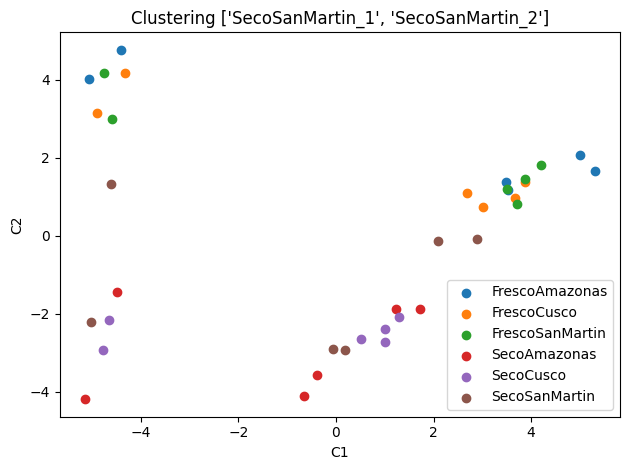

In [45]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = np.unique(labels)

for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/clustering_{encoder}_{str(train_set)}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [46]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3).fit_transform(X_scaled)

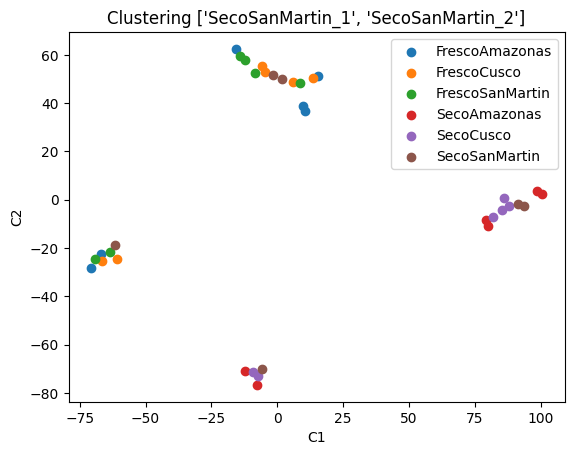

In [47]:
x, y = X_tsne[:, 0], X_tsne[:, 1]

unique_groups = np.unique(labels)

plt.figure()
for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [48]:
# import torch
# print(torch.cuda.memory_summary())